ref: https://github.com/aitorzip/PyTorch-CycleGAN

ref: https://github.com/ankmathur96/cycle-gan/blob/master/cyclegan.py

# Download Dataset & Data Handle

In [ ]:
!nvidia-smi -L

In [ ]:
! mkdir datasets

In [ ]:
! pip install torch torchvision

In [ ]:
! python -c "import torch; print('torch version: ', torch.__version__)"
! python -c "import torchvision; print('torchvision version: ', torchvision.__version__)"

In [1]:
! mkdir cyclegan
! mkdir cyclegan/model cyclegan/fig

In [2]:
model_name = "cyclegan"

In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([transforms.Resize(28), 
                                      transforms.Grayscale(3),
                                        transforms.ToTensor(), 
                                        transforms.Normalize([0.5], [0.5])
                                        ])

svhn_transform = transforms.Compose([transforms.Resize(28), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5], [0.5])
                                ])

mnist_trainset = datasets.MNIST(root='./datasets/mnist',  
                                download=True, 
                                transform=mnist_transform)
svhn_trainset = datasets.SVHN(root='./datasets/svhn',  
                                download=True, 
                                transform=svhn_transform)

Using downloaded and verified file: ./datasets/svhn/train_32x32.mat


In [4]:
from torch.utils import data
batch_size = 64
dataloader_A = data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
dataloader_B = data.DataLoader(svhn_trainset, batch_size=batch_size, shuffle=True)

In [5]:
# mnist
imgs, targets = next(iter(dataloader_A))
print( imgs.mean(), imgs.std(), imgs.max(), imgs.min()  )
print( imgs.dtype, targets.dtype )
print( imgs.shape, targets.shape )
print( dataloader_A.dataset.data.shape )

tensor(-0.7302) tensor(0.6253) tensor(1.) tensor(-1.)
torch.float32 torch.int64
torch.Size([64, 3, 28, 28]) torch.Size([64])
torch.Size([60000, 28, 28])


In [6]:
# svhn
imgs, targets = next(iter(dataloader_B))
print( imgs.mean(), imgs.std(), imgs.max(), imgs.min()  )
print( imgs.dtype, targets.dtype )
print( imgs.shape, targets.shape )
print( dataloader_B.dataset.data.shape )

tensor(-0.0733) tensor(0.3423) tensor(1.) tensor(-1.)
torch.float32 torch.int64
torch.Size([64, 3, 28, 28]) torch.Size([64])
(73257, 3, 32, 32)


# Model

In [7]:
import torch
from torch import nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        model = [nn.Conv2d(  3,  64, 4, stride=2, padding=1, bias=False), 
                 nn.BatchNorm2d(64),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d( 64, 128, 4, stride=2, padding=1, bias=False), 
                 nn.BatchNorm2d(128),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False), 
                 nn.BatchNorm2d(128),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
                 nn.BatchNorm2d(128),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                 nn.BatchNorm2d(64),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.ConvTranspose2d( 64,  3, 4, stride=2, padding=1, bias=False),
                 nn.BatchNorm2d(3),
                 nn.Tanh()
                ]
        
        self.model = nn.Sequential(*model)
    def forward(self, z):
        img = self.model(z)
        return img 
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        model = [nn.Conv2d(  3,  64, 4, stride=2, padding=1, bias=False), 
                 nn.BatchNorm2d(64),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d( 64, 128, 4, stride=2, padding=1, bias=False), 
                 nn.BatchNorm2d(128),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                 nn.BatchNorm2d(256),
                 nn.Flatten(),
                 nn.Linear(2304, 1),
                 #nn.Sigmoid()  # for wGAN
                ]
        self.model = nn.Sequential(*model) 
    def forward(self, img):
        validity = self.model(img)
        return validity

# try
#G = Generator()
#D = Discriminator()
#print( G(imgs).shape )
#print( D(imgs).shape )

In [8]:
# Networks
use_cuda =  torch.cuda.is_available() 
netG_A2B = Generator()
netG_B2A = Generator()
netD_A = Discriminator()
netD_B = Discriminator()

if use_cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)
        
        
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  import sys


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten()
    (9): Linear(in_features=2304, out_features=1, bias=True)
  )
)

mnist2svhn


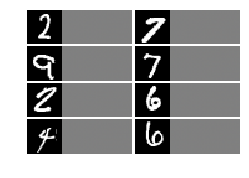

svhn2mnist


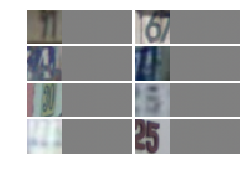

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
%matplotlib inline
rescale_fn = lambda t : torch.clamp(((t+1)*0.5*256).long(), min=0, max=255)
def show_img(img):
    data = rescale_fn(img).cpu().detach().numpy().transpose((1, 2, 0))
    plt.axis('off')
    imgplot = plt.imshow(data)
    
def show_imgs(imgs, n_height=4, n_width=2):  # imgs: torch.Size([64, 3, 28, 28])
    assert len(imgs) == n_height* n_width
    imgs = rescale_fn(imgs).cpu().detach().numpy().transpose((0, 2, 3, 1))
    fig = plt.figure(figsize = (n_height, n_width) )
    gs1 = gridspec.GridSpec(n_height, n_width,  left=0, bottom=0, right=0.75, top=1 )
    gs1.update(wspace=0.0, hspace=0.05) # set the spacing between axes.
    for i in range(len(imgs)):
        plottable_image = imgs[i]
        # i = i + 1 # grid spec indexes from 0
        ax = plt.subplot(gs1[i])
        ax.axis('off')
        ax.set_aspect('equal')
        ax.imshow(plottable_image)
        
def sample_img(G_to, G_back, data_loader, PATH="test.jpg"):
    G_to.eval()
    G_back.eval()
    imgs_batch, _ = next(iter(data_loader))
    if use_cuda: imgs_batch = imgs_batch.cuda()
    imgs_to_batch = G_to(imgs_batch)
    imgs_back_batch = G_back(imgs_to_batch)
    imgs_dual_batch = torch.cat((imgs_batch, imgs_to_batch, imgs_back_batch), 3)
    show_imgs(imgs_dual_batch[:8]) #印整個batch出來看
    plt.savefig(PATH)
    plt.show()
    G_to.train()
    G_back.train()

# before load
print('mnist2svhn');sample_img(netG_A2B,  netG_B2A, dataloader_A)
print('svhn2mnist');sample_img(netG_B2A,  netG_A2B, dataloader_B)

In [11]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Train

In [12]:
# Optimizers 
import itertools
lr = 0.0002
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor
input_A = Tensor(batch_size, 3, 28, 28)
input_B = Tensor(batch_size, 3, 28, 28)
target_real = Tensor(batch_size, 1).fill_(1.0)
target_fake = Tensor(batch_size, 1).fill_(0.0)

In [14]:
start_epo = 0

[Epoch 0/100] [D_A loss: 0.134755] [D_B loss: 0.046804] [G loss: 19.713152]
mnist2svhn


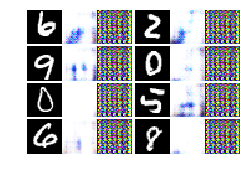

svhn2mnist


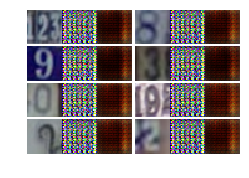

[Epoch 9/100] [D_A loss: 0.014171] [D_B loss: 0.042626] [G loss: 21.917646]
mnist2svhn


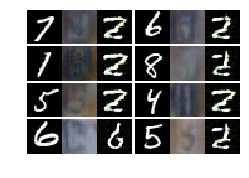

svhn2mnist


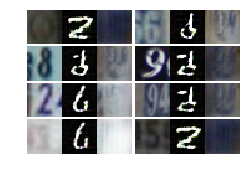

[Epoch 19/100] [D_A loss: 0.056286] [D_B loss: 0.108533] [G loss: 14.309297]
mnist2svhn


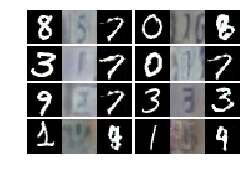

svhn2mnist


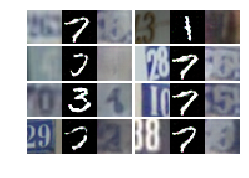

[Epoch 29/100] [D_A loss: 0.007134] [D_B loss: 0.086608] [G loss: 21.863705]
mnist2svhn


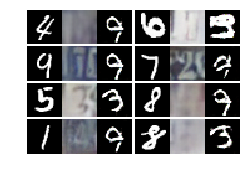

svhn2mnist


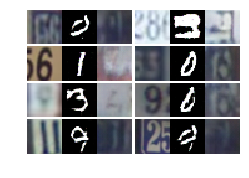

[Epoch 39/100] [D_A loss: 0.005881] [D_B loss: 0.036838] [G loss: 28.642319]
mnist2svhn


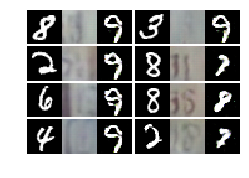

svhn2mnist


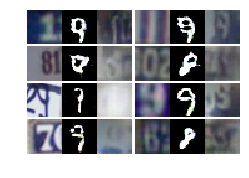

[Epoch 49/100] [D_A loss: 0.025453] [D_B loss: 0.069167] [G loss: 17.034538]
mnist2svhn


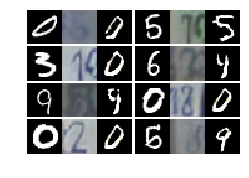

svhn2mnist


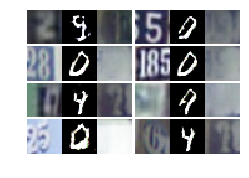

[Epoch 59/100] [D_A loss: 0.013969] [D_B loss: 0.022382] [G loss: 24.014450]
mnist2svhn


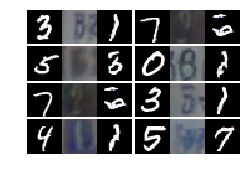

svhn2mnist


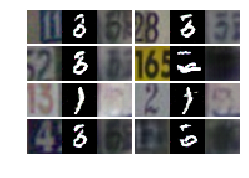

[Epoch 69/100] [D_A loss: 0.018110] [D_B loss: 0.030859] [G loss: 28.428593]
mnist2svhn


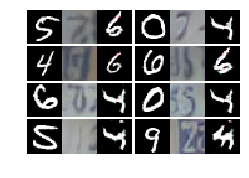

svhn2mnist


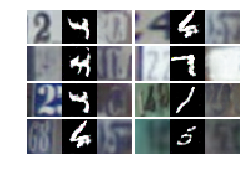

[Epoch 79/100] [D_A loss: 0.018330] [D_B loss: 0.063268] [G loss: 22.302618]
mnist2svhn


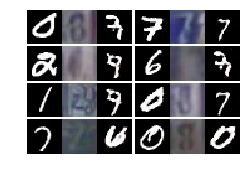

svhn2mnist


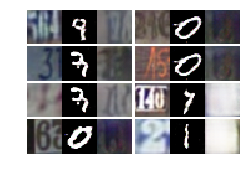

[Epoch 89/100] [D_A loss: 0.005336] [D_B loss: 0.014166] [G loss: 28.070551]
mnist2svhn


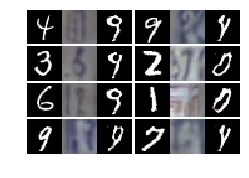

svhn2mnist


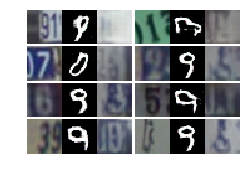

[Epoch 99/100] [D_A loss: 0.002568] [D_B loss: 0.013721] [G loss: 24.039234]
mnist2svhn


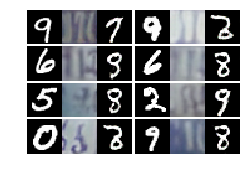

svhn2mnist


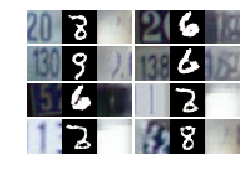

In [16]:
###### Training ######
   
n_epochs = 100
decay_epoch = 50
print_freq = 10
netG_A2B.train()
netG_B2A.train()
netD_A.train()
netD_B.train()
n_batch = int(70000/batch_size)

for epoch in range(n_epochs):
    for i in range(n_batch):
        # Set model input
        batch_A = next(iter(dataloader_A))[0]
        batch_B = next(iter(dataloader_B))[0]
        real_A = input_A.copy_(batch_A)
        real_B = input_B.copy_(batch_B)

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()
        
        # GAN loss
        c = 10.0 # hyperparam
            
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)*c

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)*c

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        #loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB

        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
    
    if epoch==0 or epoch%print_freq==(print_freq-1) or epoch==n_epochs-1:         
        print(
            "[Epoch %d/%d] [D_A loss: %f] [D_B loss: %f] [G loss: %f]"
            % (epoch, n_epochs, loss_D_A.item(), loss_D_B.item(), loss_G.item())
        )
        # save out
        this_epo_str = str(epoch+start_epo).zfill(4) 
        torch.save(netG_A2B.state_dict(), f"{model_name}/model/netG_A2B_{this_epo_str}")
        torch.save(netG_B2A.state_dict(), f"{model_name}/model/netG_B2A_{this_epo_str}")
        torch.save(netD_A.state_dict(), f"{model_name}/model/netD_A_{this_epo_str}")
        torch.save(netD_B.state_dict(), f"{model_name}/model/netD_B_{this_epo_str}")
        #sample_img(G, dataloader, f"{model_name}/fig/{this_epo_str}.jpg")
        
        print('mnist2svhn')
        sample_img(netG_A2B,  netG_B2A, dataloader_A, f"{model_name}/fig/{this_epo_str}_mnist2svhn.jpg")
        print('svhn2mnist')
        sample_img(netG_B2A,  netG_A2B, dataloader_B, f"{model_name}/fig/{this_epo_str}_svhn2mnist.jpg")
    
    ###################################

- conclusion: 
    - After refer to https://github.com/yunjey/mnist-svhn-transfer/blob/master/solver.py --> Use it's labels information may help